In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pickle
import time

In [2]:
device = torch.device('cpu')

In [3]:
# Define the exact solution
def exact_solution(x, t):
    return -torch.sin(pi*x)*torch.exp(-pi * t)

def initial_condition(x):
    return -torch.sin(pi*x)

In [4]:
# assigning number of points
initial_pts = 200 
left_boundary_pts = 200 
right_boundary_pts = 200
residual_pts = 1000

In [5]:
# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"

x_init = 2*torch.rand((initial_pts,1))-1 # initial pts
t_init =  0*x_init
init =  torch.cat([x_init, t_init],1).to(device)
u_init = initial_condition(init[:,0]).reshape(-1, 1)



xb_left = -torch.ones((left_boundary_pts, 1)) # left spatial boundary
tb_left = torch.rand((left_boundary_pts, 1)) # 
b_left = torch.cat([xb_left, tb_left ],1).to(device)
u_b_l = 0*xb_left



xb_right = torch.ones((right_boundary_pts, 1)) # right spatial boundary
tb_right = torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, tb_right ],1).to(device)
u_b_r = 0*xb_right


x_interior = 2*torch.rand((residual_pts, 1))-1
t_interior = torch.rand((residual_pts, 1))
interior = torch.cat([x_interior, t_interior],1).to(device)

In [6]:
training_set = DataLoader(torch.utils.data.TensorDataset(init.to(device), u_init.to(device), b_left.to(device),  b_right.to(device), u_b_l.to(device), u_b_r.to(device)), batch_size=500, shuffle=False)


In [7]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer 
        self.neurons = neurons
        # Number of hidden layers 
        self.n_hidden_layers = n_hidden_layers
        # Activation function 
        self.activation = nn.Tanh()
        
        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network 
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)


In [8]:
# Model definition
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = u_init.shape[1], n_hidden_layers=4, neurons=20)
my_network = my_network.to(device)

In [9]:
def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

# Random Seed for weight initialization
retrain = 128
# Xavier weight initialization
init_xavier(my_network, retrain)


In [10]:
if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")

In [11]:
def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()
    
    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])
        
        # Loop over batches
        for j, (initial, u_initial, bd_left,  bd_right, ubl, ubr) in enumerate(training_set):
            
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # for initial
                u_initial_pred_ = model(initial)
                # for left boundary
                u_bd_left_pred_ = model(bd_left)
                # for right boundary
                u_bd_right_pred_ = model(bd_right)
                
                # residual calculation
                interior.requires_grad = True
                u_hat = model(interior)
                inputs = torch.ones(residual_pts, 1 ).to(device)
                inputs2 = torch.ones(residual_pts, 1).to(device)
                grad_u_hat = torch.autograd.grad(u_hat, interior, grad_outputs=inputs, create_graph=True)[0]
                
                u_x = grad_u_hat[:, 0]
                
                grad_grad_u_x = torch.autograd.grad(u_x, interior, grad_outputs=torch.ones(interior.shape[0]), create_graph=True)[0]
                u_xx = grad_grad_u_x[:, 0]
                u_t =  grad_u_hat[:, 1]
                
                
                # Item 1. below
                loss = torch.mean((u_initial_pred_.reshape(-1, ) - u_initial.reshape(-1, ))**p) + torch.mean((u_t.reshape(-1, ) - (1/pi)*u_xx.reshape(-1, ))**p)+torch.mean((u_bd_left_pred_.reshape(-1,))**p) + torch.mean((u_bd_right_pred_.reshape(-1,))**p)
                #loss = torch.max(torch.abs((u_initial_pred_.reshape(-1, ) - u_initial.reshape(-1, )))) + torch.max(torch.abs((u_t.reshape(-1, ) - u_xx.reshape(-1, ))))+torch.max(torch.abs((u_bd_left_pred_.reshape(-1,)))) + torch.max(torch.abs((u_bd_right_pred_.reshape(-1,))))
 
                
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss
            
            # Item 3. below
            optimizer.step(closure=closure)
            
        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history


In [12]:
n_epochs = 5000
history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )

################################  0  ################################
Loss:  36.733829498291016
################################  1  ################################
Loss:  35.983280181884766
################################  2  ################################
Loss:  31.618017196655273
################################  3  ################################
Loss:  25.225664138793945
################################  4  ################################
Loss:  19.80685043334961
################################  5  ################################
Loss:  16.60009765625
################################  6  ################################
Loss:  13.733736038208008
################################  7  ################################
Loss:  10.863040924072266
################################  8  ################################
Loss:  8.254741668701172
################################  9  ################################
Loss:  6.231741428375244
################################  10  #########

Loss:  0.0038230656646192074
################################  113  ################################
Loss:  0.0037473607808351517
################################  114  ################################
Loss:  0.0036710218992084265
################################  115  ################################
Loss:  0.0035921940580010414
################################  116  ################################
Loss:  0.0035113259218633175
################################  117  ################################
Loss:  0.0034286268055438995
################################  118  ################################
Loss:  0.003344978205859661
################################  119  ################################
Loss:  0.0032616714015603065
################################  120  ################################
Loss:  0.0031785282772034407
################################  121  ################################
Loss:  0.00309564545750618
################################  122  ##########################

Loss:  0.0005633094115182757
################################  199  ################################
Loss:  0.0005551989888772368
################################  200  ################################
Loss:  0.0005473695928230882
################################  201  ################################
Loss:  0.0005395948537625372
################################  202  ################################
Loss:  0.0005318222101777792
################################  203  ################################
Loss:  0.0005239509628154337
################################  204  ################################
Loss:  0.0005160514847375453
################################  205  ################################
Loss:  0.0005081727867946029
################################  206  ################################
Loss:  0.0005003367550671101
################################  207  ################################
Loss:  0.0004926071269437671
################################  208  #######################

Loss:  0.00014666272909380496
################################  302  ################################
Loss:  0.0001449986157240346
################################  303  ################################
Loss:  0.0001429907133569941
################################  304  ################################
Loss:  0.00014137024118099362
################################  305  ################################
Loss:  0.00013951974688097835
################################  306  ################################
Loss:  0.00013758875138591975
################################  307  ################################
Loss:  0.00013550440780818462
################################  308  ################################
Loss:  0.00013334679533727467
################################  309  ################################
Loss:  0.0001311720407102257
################################  310  ################################
Loss:  0.00012898774002678692
################################  311  ################

Loss:  6.202836812008172e-05
################################  386  ################################
Loss:  6.128599488874897e-05
################################  387  ################################
Loss:  6.040502557880245e-05
################################  388  ################################
Loss:  5.932755448156968e-05
################################  389  ################################
Loss:  5.8210276620229706e-05
################################  390  ################################
Loss:  5.701195914298296e-05
################################  391  ################################
Loss:  5.5863223678898066e-05
################################  392  ################################
Loss:  5.47433337487746e-05
################################  393  ################################
Loss:  5.3608451707987115e-05
################################  394  ################################
Loss:  5.255716678220779e-05
################################  395  #####################

Loss:  2.470294202794321e-05
################################  479  ################################
Loss:  2.4551678507123142e-05
################################  480  ################################
Loss:  2.439413219690323e-05
################################  481  ################################
Loss:  2.4226936147897504e-05
################################  482  ################################
Loss:  2.405798659310676e-05
################################  483  ################################
Loss:  2.388526263530366e-05
################################  484  ################################
Loss:  2.3701337340753525e-05
################################  485  ################################
Loss:  2.352000774408225e-05
################################  486  ################################
Loss:  2.3345422960119322e-05
################################  487  ################################
Loss:  2.3184669771580957e-05
################################  488  ##################

Loss:  1.3435259461402893e-05
################################  589  ################################
Loss:  1.3399423551163636e-05
################################  590  ################################
Loss:  1.336398781859316e-05
################################  591  ################################
Loss:  1.3329902685654815e-05
################################  592  ################################
Loss:  1.329495535173919e-05
################################  593  ################################
Loss:  1.3262096217658836e-05
################################  594  ################################
Loss:  1.3228663192421664e-05
################################  595  ################################
Loss:  1.3195827705203556e-05
################################  596  ################################
Loss:  1.316316775046289e-05
################################  597  ################################
Loss:  1.312864333158359e-05
################################  598  #################

Loss:  9.817911632126197e-06
################################  682  ################################
Loss:  9.790323019842617e-06
################################  683  ################################
Loss:  9.764016795088537e-06
################################  684  ################################
Loss:  9.739526831253897e-06
################################  685  ################################
Loss:  9.716273780213669e-06
################################  686  ################################
Loss:  9.69498523772927e-06
################################  687  ################################
Loss:  9.67414234764874e-06
################################  688  ################################
Loss:  9.65439267019974e-06
################################  689  ################################
Loss:  9.635175047151279e-06
################################  690  ################################
Loss:  9.617040632292628e-06
################################  691  ##########################

Loss:  7.634968824277166e-06
################################  767  ################################
Loss:  7.627466402482241e-06
################################  768  ################################
Loss:  7.618378731422126e-06
################################  769  ################################
Loss:  7.607266070408514e-06
################################  770  ################################
Loss:  7.598961019539274e-06
################################  771  ################################
Loss:  7.588400876556989e-06
################################  772  ################################
Loss:  7.575772997370223e-06
################################  773  ################################
Loss:  7.560648100479739e-06
################################  774  ################################
Loss:  7.545114385720808e-06
################################  775  ################################
Loss:  7.5275652307027485e-06
################################  776  ######################

Loss:  5.879805030417629e-06
################################  861  ################################
Loss:  5.867680101800943e-06
################################  862  ################################
Loss:  5.856030838913284e-06
################################  863  ################################
Loss:  5.842686277901521e-06
################################  864  ################################
Loss:  5.831665021105437e-06
################################  865  ################################
Loss:  5.81934455112787e-06
################################  866  ################################
Loss:  5.8052528402186e-06
################################  867  ################################
Loss:  5.790379418613156e-06
################################  868  ################################
Loss:  5.777804744866444e-06
################################  869  ################################
Loss:  5.765114565292606e-06
################################  870  ##########################

Loss:  4.54883229394909e-06
################################  957  ################################
Loss:  4.531625563686248e-06
################################  958  ################################
Loss:  4.511162842391059e-06
################################  959  ################################
Loss:  4.4922867346031126e-06
################################  960  ################################
Loss:  4.471556621865602e-06
################################  961  ################################
Loss:  4.447297669685213e-06
################################  962  ################################
Loss:  4.426324721862329e-06
################################  963  ################################
Loss:  4.405852905620122e-06
################################  964  ################################
Loss:  4.383252871775767e-06
################################  965  ################################
Loss:  4.364507731224876e-06
################################  966  #######################

Loss:  3.609374971347279e-06
################################  1051  ################################
Loss:  3.603036020649597e-06
################################  1052  ################################
Loss:  3.5960422337666387e-06
################################  1053  ################################
Loss:  3.5885796023649164e-06
################################  1054  ################################
Loss:  3.5813193335343385e-06
################################  1055  ################################
Loss:  3.5746479625231586e-06
################################  1056  ################################
Loss:  3.567753537936369e-06
################################  1057  ################################
Loss:  3.560995992302196e-06
################################  1058  ################################
Loss:  3.554787781467894e-06
################################  1059  ################################
Loss:  3.548163931554882e-06
################################  1060  #########

################################  1144  ################################
Loss:  3.01336058328161e-06
################################  1145  ################################
Loss:  3.00955935017555e-06
################################  1146  ################################
Loss:  3.005842017955729e-06
################################  1147  ################################
Loss:  3.0026310469111195e-06
################################  1148  ################################
Loss:  2.999452817675774e-06
################################  1149  ################################
Loss:  2.995920340254088e-06
################################  1150  ################################
Loss:  2.9923819511168404e-06
################################  1151  ################################
Loss:  2.988607775478158e-06
################################  1152  ################################
Loss:  2.9856428227503784e-06
################################  1153  ################################
Loss:  2

Loss:  2.4653145374031737e-06
################################  1233  ################################
Loss:  2.460657697156421e-06
################################  1234  ################################
Loss:  2.4556220523663796e-06
################################  1235  ################################
Loss:  2.4509502054570476e-06
################################  1236  ################################
Loss:  2.443985977151897e-06
################################  1237  ################################
Loss:  2.4352552827622276e-06
################################  1238  ################################
Loss:  2.4256498818431282e-06
################################  1239  ################################
Loss:  2.415611561445985e-06
################################  1240  ################################
Loss:  2.4058649614744354e-06
################################  1241  ################################
Loss:  2.395215688011376e-06
################################  1242  #######

Loss:  1.9160959254804766e-06
################################  1325  ################################
Loss:  1.9102662918157876e-06
################################  1326  ################################
Loss:  1.9046752868234762e-06
################################  1327  ################################
Loss:  1.8994735455635237e-06
################################  1328  ################################
Loss:  1.894338424790476e-06
################################  1329  ################################
Loss:  1.889522764031426e-06
################################  1330  ################################
Loss:  1.8849624439098989e-06
################################  1331  ################################
Loss:  1.8806418893291266e-06
################################  1332  ################################
Loss:  1.8764922060654499e-06
################################  1333  ################################
Loss:  1.8725609152170364e-06
################################  1334  #####

Loss:  1.70329269622016e-06
################################  1407  ################################
Loss:  1.70118948972231e-06
################################  1408  ################################
Loss:  1.6992164546536515e-06
################################  1409  ################################
Loss:  1.697376092124614e-06
################################  1410  ################################
Loss:  1.6954668353719171e-06
################################  1411  ################################
Loss:  1.6937566442720708e-06
################################  1412  ################################
Loss:  1.6922269878705265e-06
################################  1413  ################################
Loss:  1.6904804169826093e-06
################################  1414  ################################
Loss:  1.6892540770641062e-06
################################  1415  ################################
Loss:  1.6879603208508343e-06
################################  1416  ########

Loss:  1.5172980738498154e-06
################################  1492  ################################
Loss:  1.5171298173299874e-06
################################  1493  ################################
Loss:  1.5169363223321852e-06
################################  1494  ################################
Loss:  1.5167723859121907e-06
################################  1495  ################################
Loss:  1.5167114497671719e-06
################################  1496  ################################
Loss:  1.5166343700911966e-06
################################  1497  ################################
Loss:  1.5163869875323144e-06
################################  1498  ################################
Loss:  1.5163429907261161e-06
################################  1499  ################################
Loss:  1.5162833051363123e-06
################################  1500  ################################
Loss:  1.5161558621912263e-06
################################  1501  ###

Loss:  1.5135000239752117e-06
################################  1587  ################################
Loss:  1.5134289697016357e-06
################################  1588  ################################
Loss:  1.5134251043491531e-06
################################  1589  ################################
Loss:  1.5133880424400559e-06
################################  1590  ################################
Loss:  1.5132453654587152e-06
################################  1591  ################################
Loss:  1.5134691011553514e-06
################################  1592  ################################
Loss:  1.5133750821405556e-06
################################  1593  ################################
Loss:  1.5132967519093654e-06
################################  1594  ################################
Loss:  1.5133772421904723e-06
################################  1595  ################################
Loss:  1.5132392263694783e-06
################################  1596  ###

Loss:  1.5117939256015234e-06
################################  1668  ################################
Loss:  1.5116743270482402e-06
################################  1669  ################################
Loss:  1.5115814449018217e-06
################################  1670  ################################
Loss:  1.5115120959308115e-06
################################  1671  ################################
Loss:  1.5114644611458061e-06
################################  1672  ################################
Loss:  1.5115169844648335e-06
################################  1673  ################################
Loss:  1.5115546148081194e-06
################################  1674  ################################
Loss:  1.5114778761926573e-06
################################  1675  ################################
Loss:  1.5114644611458061e-06
################################  1676  ################################
Loss:  1.5114410416572355e-06
################################  1677  ###

Loss:  1.5098486301212688e-06
################################  1753  ################################
Loss:  1.509812591393711e-06
################################  1754  ################################
Loss:  1.509900812379783e-06
################################  1755  ################################
Loss:  1.5097710956979427e-06
################################  1756  ################################
Loss:  1.5098054291229346e-06
################################  1757  ################################
Loss:  1.5097563164090388e-06
################################  1758  ################################
Loss:  1.5097016330400947e-06
################################  1759  ################################
Loss:  1.5097878076630877e-06
################################  1760  ################################
Loss:  1.5097018604137702e-06
################################  1761  ################################
Loss:  1.5096867400643532e-06
################################  1762  #####

Loss:  1.5081120636750711e-06
################################  1845  ################################
Loss:  1.5078918522704043e-06
################################  1846  ################################
Loss:  1.508074092271272e-06
################################  1847  ################################
Loss:  1.5079535842232872e-06
################################  1848  ################################
Loss:  1.5080129287525779e-06
################################  1849  ################################
Loss:  1.5080375987963635e-06
################################  1850  ################################
Loss:  1.5080391904120916e-06
################################  1851  ################################
Loss:  1.5079905324455467e-06
################################  1852  ################################
Loss:  1.507928345745313e-06
################################  1853  ################################
Loss:  1.5079893955771695e-06
################################  1854  #####

Loss:  1.5066726746226777e-06
################################  1925  ################################
Loss:  1.5067193999129813e-06
################################  1926  ################################
Loss:  1.5065951401993516e-06
################################  1927  ################################
Loss:  1.5066149217091152e-06
################################  1928  ################################
Loss:  1.5066924561324413e-06
################################  1929  ################################
Loss:  1.5065927527757594e-06
################################  1930  ################################
Loss:  1.5064882745718933e-06
################################  1931  ################################
Loss:  1.5066757441672962e-06
################################  1932  ################################
Loss:  1.5065057823449024e-06
################################  1933  ################################
Loss:  1.5066940477481694e-06
################################  1934  ###

################################  2005  ################################
Loss:  1.5052728485898115e-06
################################  2006  ################################
Loss:  1.5052686421768158e-06
################################  2007  ################################
Loss:  1.5053141169119044e-06
################################  2008  ################################
Loss:  1.5053327615532908e-06
################################  2009  ################################
Loss:  1.5052185062813805e-06
################################  2010  ################################
Loss:  1.5052984281282988e-06
################################  2011  ################################
Loss:  1.505159957559954e-06
################################  2012  ################################
Loss:  1.5050882211653516e-06
################################  2013  ################################
Loss:  1.50525795561407e-06
################################  2014  ################################
Los

Loss:  1.503993985352281e-06
################################  2090  ################################
Loss:  1.5039573781905347e-06
################################  2091  ################################
Loss:  1.5039724985399516e-06
################################  2092  ################################
Loss:  1.5039714753584121e-06
################################  2093  ################################
Loss:  1.5038256151456153e-06
################################  2094  ################################
Loss:  1.5038565379654756e-06
################################  2095  ################################
Loss:  1.5039473737488152e-06
################################  2096  ################################
Loss:  1.5039504432934336e-06
################################  2097  ################################
Loss:  1.5039138361316873e-06
################################  2098  ################################
Loss:  1.5039113350212574e-06
################################  2099  ####

Loss:  1.5026752180347103e-06
################################  2174  ################################
Loss:  1.5026349728941568e-06
################################  2175  ################################
Loss:  1.5025887023512041e-06
################################  2176  ################################
Loss:  1.5026752180347103e-06
################################  2177  ################################
Loss:  1.5026220125946566e-06
################################  2178  ################################
Loss:  1.5026533901618677e-06
################################  2179  ################################
Loss:  1.502607574366266e-06
################################  2180  ################################
Loss:  1.502529926256102e-06
################################  2181  ################################
Loss:  1.5026156461317441e-06
################################  2182  ################################
Loss:  1.502555278420914e-06
################################  2183  ######

Loss:  1.5013191614343668e-06
################################  2267  ################################
Loss:  1.5013149550213711e-06
################################  2268  ################################
Loss:  1.5012783478596248e-06
################################  2269  ################################
Loss:  1.5012619769549929e-06
################################  2270  ################################
Loss:  1.5012011544968118e-06
################################  2271  ################################
Loss:  1.5012709582151729e-06
################################  2272  ################################
Loss:  1.5012049061624566e-06
################################  2273  ################################
Loss:  1.5012858511909144e-06
################################  2274  ################################
Loss:  1.5012192307040095e-06
################################  2275  ################################
Loss:  1.5013238225947134e-06
################################  2276  ###

Loss:  1.4999250197433867e-06
################################  2360  ################################
Loss:  1.4999915265434538e-06
################################  2361  ################################
Loss:  1.499957988926326e-06
################################  2362  ################################
Loss:  1.4998523738540825e-06
################################  2363  ################################
Loss:  1.4999385484770755e-06
################################  2364  ################################
Loss:  1.4998744291006005e-06
################################  2365  ################################
Loss:  1.4998707911217934e-06
################################  2366  ################################
Loss:  1.499890572631557e-06
################################  2367  ################################
Loss:  1.4998639699115301e-06
################################  2368  ################################
Loss:  1.4999384347902378e-06
################################  2369  #####

Loss:  1.4987735994509421e-06
################################  2440  ################################
Loss:  1.498864321547444e-06
################################  2441  ################################
Loss:  1.4987341501182527e-06
################################  2442  ################################
Loss:  1.498896153862006e-06
################################  2443  ################################
Loss:  1.4988049770181533e-06
################################  2444  ################################
Loss:  1.4988024759077234e-06
################################  2445  ################################
Loss:  1.4986998166932608e-06
################################  2446  ################################
Loss:  1.4988385146352812e-06
################################  2447  ################################
Loss:  1.4987627992013586e-06
################################  2448  ################################
Loss:  1.4987098211349803e-06
################################  2449  #####

Loss:  1.497536686656531e-06
################################  2533  ################################
Loss:  1.4975402109485003e-06
################################  2534  ################################
Loss:  1.4975884141676943e-06
################################  2535  ################################
Loss:  1.4975393014537985e-06
################################  2536  ################################
Loss:  1.4976226339058485e-06
################################  2537  ################################
Loss:  1.4975584008425358e-06
################################  2538  ################################
Loss:  1.4975396425143117e-06
################################  2539  ################################
Loss:  1.4975528301874874e-06
################################  2540  ################################
Loss:  1.4974885971241747e-06
################################  2541  ################################
Loss:  1.4975257727201097e-06
################################  2542  ####

Loss:  1.4965660284360638e-06
################################  2614  ################################
Loss:  1.4965149830459268e-06
################################  2615  ################################
Loss:  1.4964631418479257e-06
################################  2616  ################################
Loss:  1.4966277603889466e-06
################################  2617  ################################
Loss:  1.4964708725528908e-06
################################  2618  ################################
Loss:  1.496445861448592e-06
################################  2619  ################################
Loss:  1.496477352702641e-06
################################  2620  ################################
Loss:  1.496423806202074e-06
################################  2621  ################################
Loss:  1.4964256251914776e-06
################################  2622  ################################
Loss:  1.4964408592277323e-06
################################  2623  ######

Loss:  1.4953277513996e-06
################################  2700  ################################
Loss:  1.4954190419302904e-06
################################  2701  ################################
Loss:  1.4954341622797074e-06
################################  2702  ################################
Loss:  1.4954752032281249e-06
################################  2703  ################################
Loss:  1.4953999425415532e-06
################################  2704  ################################
Loss:  1.4953502613934688e-06
################################  2705  ################################
Loss:  1.4953774325476843e-06
################################  2706  ################################
Loss:  1.4954964626667788e-06
################################  2707  ################################
Loss:  1.4952832998460508e-06
################################  2708  ################################
Loss:  1.4953582194721093e-06
################################  2709  ######

Loss:  1.4943981341275503e-06
################################  2788  ################################
Loss:  1.4944364465918625e-06
################################  2789  ################################
Loss:  1.4942260122552398e-06
################################  2790  ################################
Loss:  1.494254888712021e-06
################################  2791  ################################
Loss:  1.494385969635914e-06
################################  2792  ################################
Loss:  1.4943124142519082e-06
################################  2793  ################################
Loss:  1.4942294228603714e-06
################################  2794  ################################
Loss:  1.4942260122552398e-06
################################  2795  ################################
Loss:  1.4942454527044902e-06
################################  2796  ################################
Loss:  1.494318212280632e-06
################################  2797  ######

Loss:  1.4932402336853556e-06
################################  2871  ################################
Loss:  1.4932751355445362e-06
################################  2872  ################################
Loss:  1.493363811277959e-06
################################  2873  ################################
Loss:  1.493262516305549e-06
################################  2874  ################################
Loss:  1.4933330021449365e-06
################################  2875  ################################
Loss:  1.4932975318515673e-06
################################  2876  ################################
Loss:  1.493231479798851e-06
################################  2877  ################################
Loss:  1.49326945120265e-06
################################  2878  ################################
Loss:  1.4932522844901541e-06
################################  2879  ################################
Loss:  1.4932112435417366e-06
################################  2880  ########

Loss:  1.492128035351925e-06
################################  2974  ################################
Loss:  1.4920309467925108e-06
################################  2975  ################################
Loss:  1.4920924513717182e-06
################################  2976  ################################
Loss:  1.492064370722801e-06
################################  2977  ################################
Loss:  1.4920625517333974e-06
################################  2978  ################################
Loss:  1.4920482271918445e-06
################################  2979  ################################
Loss:  1.492152136961522e-06
################################  2980  ################################
Loss:  1.4920011608410277e-06
################################  2981  ################################
Loss:  1.4920473176971427e-06
################################  2982  ################################
Loss:  1.4920441344656865e-06
################################  2983  ######

Loss:  1.490918407398567e-06
################################  3068  ################################
Loss:  1.4910061736372882e-06
################################  3069  ################################
Loss:  1.4910436902937363e-06
################################  3070  ################################
Loss:  1.490999693487538e-06
################################  3071  ################################
Loss:  1.4909803667251254e-06
################################  3072  ################################
Loss:  1.4909556966813398e-06
################################  3073  ################################
Loss:  1.4909269339113962e-06
################################  3074  ################################
Loss:  1.4910069694451522e-06
################################  3075  ################################
Loss:  1.4910460777173284e-06
################################  3076  ################################
Loss:  1.491018906563113e-06
################################  3077  ######

Loss:  1.489818259869935e-06
################################  3174  ################################
Loss:  1.489910573582165e-06
################################  3175  ################################
Loss:  1.4898737390467431e-06
################################  3176  ################################
Loss:  1.489897044848476e-06
################################  3177  ################################
Loss:  1.4898258768880623e-06
################################  3178  ################################
Loss:  1.489721853431547e-06
################################  3179  ################################
Loss:  1.4897296978233499e-06
################################  3180  ################################
Loss:  1.489699798185029e-06
################################  3181  ################################
Loss:  1.4897975688654697e-06
################################  3182  ################################
Loss:  1.4897516393830301e-06
################################  3183  ########

Loss:  1.4888363466525334e-06
################################  3261  ################################
Loss:  1.4888061059536994e-06
################################  3262  ################################
Loss:  1.488798488935572e-06
################################  3263  ################################
Loss:  1.4888850046190782e-06
################################  3264  ################################
Loss:  1.488864654675126e-06
################################  3265  ################################
Loss:  1.4888579471517005e-06
################################  3266  ################################
Loss:  1.488856128162297e-06
################################  3267  ################################
Loss:  1.4889325257172459e-06
################################  3268  ################################
Loss:  1.4888578334648628e-06
################################  3269  ################################
Loss:  1.4889342310198117e-06
################################  3270  ######

Loss:  1.4879434502290678e-06
################################  3350  ################################
Loss:  1.4879191212457954e-06
################################  3351  ################################
Loss:  1.487989948145696e-06
################################  3352  ################################
Loss:  1.4879586842653225e-06
################################  3353  ################################
Loss:  1.4879407217449625e-06
################################  3354  ################################
Loss:  1.4878766023684875e-06
################################  3355  ################################
Loss:  1.4879841501169722e-06
################################  3356  ################################
Loss:  1.4877912235533586e-06
################################  3357  ################################
Loss:  1.4878505680826493e-06
################################  3358  ################################
Loss:  1.4879382206345326e-06
################################  3359  ####

Loss:  1.4870242921460886e-06
################################  3436  ################################
Loss:  1.4870664699628833e-06
################################  3437  ################################
Loss:  1.4870548739054357e-06
################################  3438  ################################
Loss:  1.4869817732687807e-06
################################  3439  ################################
Loss:  1.4870115592202637e-06
################################  3440  ################################
Loss:  1.487036797698238e-06
################################  3441  ################################
Loss:  1.487012696088641e-06
################################  3442  ################################
Loss:  1.4869532378725125e-06
################################  3443  ################################
Loss:  1.4870370250719134e-06
################################  3444  ################################
Loss:  1.4869871165501536e-06
################################  3445  #####

Loss:  1.4862895341138938e-06
################################  3521  ################################
Loss:  1.4862450825603446e-06
################################  3522  ################################
Loss:  1.4863019259792054e-06
################################  3523  ################################
Loss:  1.4862135913062957e-06
################################  3524  ################################
Loss:  1.4861007002764381e-06
################################  3525  ################################
Loss:  1.4861711861158255e-06
################################  3526  ################################
Loss:  1.4862218904454494e-06
################################  3527  ################################
Loss:  1.4861841464153258e-06
################################  3528  ################################
Loss:  1.4861406043564784e-06
################################  3529  ################################
Loss:  1.486075007051113e-06
################################  3530  ####

Loss:  1.4853495713396114e-06
################################  3604  ################################
Loss:  1.4853222864985582e-06
################################  3605  ################################
Loss:  1.4853925449642702e-06
################################  3606  ################################
Loss:  1.4853336551823304e-06
################################  3607  ################################
Loss:  1.4852828371658688e-06
################################  3608  ################################
Loss:  1.485319899074966e-06
################################  3609  ################################
Loss:  1.485330130890361e-06
################################  3610  ################################
Loss:  1.4852984122626367e-06
################################  3611  ################################
Loss:  1.4852054164293804e-06
################################  3612  ################################
Loss:  1.485290567870834e-06
################################  3613  ######

Loss:  1.4845992382106488e-06
################################  3690  ################################
Loss:  1.4844735005681287e-06
################################  3691  ################################
Loss:  1.4844777069811244e-06
################################  3692  ################################
Loss:  1.4845755913484027e-06
################################  3693  ################################
Loss:  1.4843546978227096e-06
################################  3694  ################################
Loss:  1.4845024907117477e-06
################################  3695  ################################
Loss:  1.4843776625639293e-06
################################  3696  ################################
Loss:  1.484606514168263e-06
################################  3697  ################################
Loss:  1.4844140423520003e-06
################################  3698  ################################
Loss:  1.4843355984339723e-06
################################  3699  ####

Loss:  1.4835588899586583e-06
################################  3791  ################################
Loss:  1.4835501360721537e-06
################################  3792  ################################
Loss:  1.4834223520665546e-06
################################  3793  ################################
Loss:  1.4835968613624573e-06
################################  3794  ################################
Loss:  1.4834869261903805e-06
################################  3795  ################################
Loss:  1.4835214869890478e-06
################################  3796  ################################
Loss:  1.4833872228336986e-06
################################  3797  ################################
Loss:  1.4834022294962779e-06
################################  3798  ################################
Loss:  1.483446681049827e-06
################################  3799  ################################
Loss:  1.4835450201644562e-06
################################  3800  ####

Loss:  1.4827959375907085e-06
################################  3873  ################################
Loss:  1.4827922996119014e-06
################################  3874  ################################
Loss:  1.4827209042778122e-06
################################  3875  ################################
Loss:  1.4827717222942738e-06
################################  3876  ################################
Loss:  1.4827811583018047e-06
################################  3877  ################################
Loss:  1.4827813856754801e-06
################################  3878  ################################
Loss:  1.482764673710335e-06
################################  3879  ################################
Loss:  1.4826746337348595e-06
################################  3880  ################################
Loss:  1.4826717915639165e-06
################################  3881  ################################
Loss:  1.4827734275968396e-06
################################  3882  ####

Loss:  1.4820110436630785e-06
################################  3959  ################################
Loss:  1.481996150687337e-06
################################  3960  ################################
Loss:  1.481881781728589e-06
################################  3961  ################################
Loss:  1.4819163425272563e-06
################################  3962  ################################
Loss:  1.4819319176240242e-06
################################  3963  ################################
Loss:  1.481926688029489e-06
################################  3964  ################################
Loss:  1.4818530189586454e-06
################################  3965  ################################
Loss:  1.481905087530322e-06
################################  3966  ################################
Loss:  1.481970002714661e-06
################################  3967  ################################
Loss:  1.481890308241418e-06
################################  3968  #########

Loss:  1.4811602113695699e-06
################################  4047  ################################
Loss:  1.4811827213634388e-06
################################  4048  ################################
Loss:  1.4812072777203866e-06
################################  4049  ################################
Loss:  1.4812084145887638e-06
################################  4050  ################################
Loss:  1.481120534663205e-06
################################  4051  ################################
Loss:  1.481018443882931e-06
################################  4052  ################################
Loss:  1.4810627817496425e-06
################################  4053  ################################
Loss:  1.4811706705586403e-06
################################  4054  ################################
Loss:  1.4811362234468106e-06
################################  4055  ################################
Loss:  1.4810967741141212e-06
################################  4056  #####

Loss:  1.4803587191636325e-06
################################  4137  ################################
Loss:  1.4802977830186137e-06
################################  4138  ################################
Loss:  1.48034587255097e-06
################################  4139  ################################
Loss:  1.4803002841290436e-06
################################  4140  ################################
Loss:  1.480312789681193e-06
################################  4141  ################################
Loss:  1.4803832755205804e-06
################################  4142  ################################
Loss:  1.4803862313783611e-06
################################  4143  ################################
Loss:  1.4802969872107496e-06
################################  4144  ################################
Loss:  1.4803124486206798e-06
################################  4145  ################################
Loss:  1.4802504892941215e-06
################################  4146  ######

Loss:  1.479566208217875e-06
################################  4236  ################################
Loss:  1.4793871514484636e-06
################################  4237  ################################
Loss:  1.479413526794815e-06
################################  4238  ################################
Loss:  1.4794973139942158e-06
################################  4239  ################################
Loss:  1.4795232345932163e-06
################################  4240  ################################
Loss:  1.4794161415920826e-06
################################  4241  ################################
Loss:  1.4794593425904168e-06
################################  4242  ################################
Loss:  1.4794457001698902e-06
################################  4243  ################################
Loss:  1.4793628224651911e-06
################################  4244  ################################
Loss:  1.4794221669944818e-06
################################  4245  #####

Loss:  1.4786154451940092e-06
################################  4336  ################################
Loss:  1.4785518942517228e-06
################################  4337  ################################
Loss:  1.4785828170715831e-06
################################  4338  ################################
Loss:  1.4785097164349281e-06
################################  4339  ################################
Loss:  1.4786044175707502e-06
################################  4340  ################################
Loss:  1.4785615576329292e-06
################################  4341  ################################
Loss:  1.478561216572416e-06
################################  4342  ################################
Loss:  1.4785242683501565e-06
################################  4343  ################################
Loss:  1.4785631492486573e-06
################################  4344  ################################
Loss:  1.4785282473894767e-06
################################  4345  ####

Loss:  1.4777617707295576e-06
################################  4418  ################################
Loss:  1.4778496506551164e-06
################################  4419  ################################
Loss:  1.4779427601752104e-06
################################  4420  ################################
Loss:  1.4778980812479858e-06
################################  4421  ################################
Loss:  1.4779698176425882e-06
################################  4422  ################################
Loss:  1.4778890999878058e-06
################################  4423  ################################
Loss:  1.4779162711420213e-06
################################  4424  ################################
Loss:  1.4778180457142298e-06
################################  4425  ################################
Loss:  1.4778961485717446e-06
################################  4426  ################################
Loss:  1.4777938304177951e-06
################################  4427  ###

Loss:  1.477065325161675e-06
################################  4518  ################################
Loss:  1.4771248970646411e-06
################################  4519  ################################
Loss:  1.477139221606194e-06
################################  4520  ################################
Loss:  1.4769780136703048e-06
################################  4521  ################################
Loss:  1.4771057976759039e-06
################################  4522  ################################
Loss:  1.4771046608075267e-06
################################  4523  ################################
Loss:  1.4769036624784349e-06
################################  4524  ################################
Loss:  1.4770970437893993e-06
################################  4525  ################################
Loss:  1.4770560028409818e-06
################################  4526  ################################
Loss:  1.4769808558412478e-06
################################  4527  #####

Loss:  1.4762291584702325e-06
################################  4609  ################################
Loss:  1.4763685385332792e-06
################################  4610  ################################
Loss:  1.4762762248210493e-06
################################  4611  ################################
Loss:  1.4763888884772314e-06
################################  4612  ################################
Loss:  1.4763315903110197e-06
################################  4613  ################################
Loss:  1.4761967577214818e-06
################################  4614  ################################
Loss:  1.4762915725441417e-06
################################  4615  ################################
Loss:  1.4762090358999558e-06
################################  4616  ################################
Loss:  1.4762390492251143e-06
################################  4617  ################################
Loss:  1.4762553064429085e-06
################################  4618  ###

Loss:  1.4754633639313397e-06
################################  4710  ################################
Loss:  1.4754527910554316e-06
################################  4711  ################################
Loss:  1.47559558172361e-06
################################  4712  ################################
Loss:  1.4755250958842225e-06
################################  4713  ################################
Loss:  1.4755222537132795e-06
################################  4714  ################################
Loss:  1.4755009942746256e-06
################################  4715  ################################
Loss:  1.4755484016859555e-06
################################  4716  ################################
Loss:  1.475419139751466e-06
################################  4717  ################################
Loss:  1.4753890127394698e-06
################################  4718  ################################
Loss:  1.4755108850295073e-06
################################  4719  ######

Loss:  1.4747524801350664e-06
################################  4813  ################################
Loss:  1.474693817726802e-06
################################  4814  ################################
Loss:  1.4748133025932475e-06
################################  4815  ################################
Loss:  1.474704504289548e-06
################################  4816  ################################
Loss:  1.4747025716133066e-06
################################  4817  ################################
Loss:  1.4746099168405635e-06
################################  4818  ################################
Loss:  1.4746775605090079e-06
################################  4819  ################################
Loss:  1.474606051488081e-06
################################  4820  ################################
Loss:  1.4746565284440294e-06
################################  4821  ################################
Loss:  1.474614236940397e-06
################################  4822  #######

Loss:  1.4738976688022376e-06
################################  4917  ################################
Loss:  1.4737913716089679e-06
################################  4918  ################################
Loss:  1.4739111975359265e-06
################################  4919  ################################
Loss:  1.473948145758186e-06
################################  4920  ################################
Loss:  1.4738959634996718e-06
################################  4921  ################################
Loss:  1.4739050584466895e-06
################################  4922  ################################
Loss:  1.4737955780219636e-06
################################  4923  ################################
Loss:  1.4739035805177991e-06
################################  4924  ################################
Loss:  1.4739705420652172e-06
################################  4925  ################################
Loss:  1.4738508298250963e-06
################################  4926  ####

Loss:  1.4734108617631136e-06
################################  4998  ################################
Loss:  1.4732780755366548e-06
################################  4999  ################################
Loss:  1.4733059288118966e-06


In [13]:
x_test = torch.linspace(-1, 1, 1000).reshape(-1,1)
t_test = torch.ones((1000,1))
test = torch.cat([x_test, t_test],1)
u_test = exact_solution(x_test, t_test).reshape(-1,1)

u_test_pred = my_network(test).reshape(-1,1)

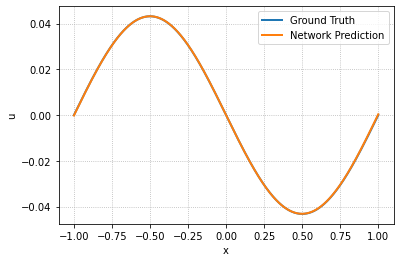

In [17]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, u_test, label="Ground Truth",lw=2)
plt.plot(x_test, u_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [15]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((u_test_pred - u_test)**2)/torch.mean(u_test**2)
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")


# Compute the relative L^\infty error norm (generalization error)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))


Relative Error Test:  0.0010341525921830907 %
